# Intelligent placer (обзор)

In [102]:
import cv2
import math
import os
import matplotlib.pyplot as plt

In [103]:
class Contours:
    def __init__(self, polygon, objects, polygon_paper=None, objects_paper=None):
        self.polygon = polygon
        self.objects = objects
        self.polygon_paper = polygon_paper
        self.objects_paper = objects_paper

    @staticmethod
    def find_contours(image):
        # blur the image
        blurred = cv2.GaussianBlur(image, (5, 5), 0)

        # highlight borders with Canny algorithm and save them as a mask
        canny_result = cv2.Canny(blurred, 50, 50 * 3, 2)
        mask = canny_result != 0
        image_tmp = 255 * (mask[:, :, None].astype(image.dtype))

        # Finding the contours of the borders
        all_contours, hierarchy = cv2.findContours(image_tmp, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

        # Getting the contours of sheets of paper
        papers_indexes = [index for index in range(len(all_contours)) if hierarchy[0][index][3] < 0]
        if len(papers_indexes) < 2:
            return None

        # Leave only the largest outer contours
        if len(papers_indexes) > 2:
            papers_indexes.sort(key=lambda x: cv2.arcLength(all_contours[x], True))
            papers_indexes = [papers_indexes[-1], papers_indexes[-2]]

        # sort contours by coordinate y
        moments = [cv2.moments(all_contours[i]) for i in papers_indexes]
        y = [moment['m01']/moment['m00'] if moment['m00'] > 0 else math.inf for moment in moments]

        # save the contours of the top and bottom sheet
        if y[0] > y[1]:
            polygon_paper = all_contours[papers_indexes[1]]
            objects_paper = all_contours[papers_indexes[0]]
            papers_indexes = [papers_indexes[1], papers_indexes[0]]
        else:
            polygon_paper = all_contours[papers_indexes[0]]
            objects_paper = all_contours[papers_indexes[1]]
            papers_indexes = [papers_indexes[0], papers_indexes[1]]

        # find polygon
        polygon_indexes = [i for i in range(len(all_contours)) if hierarchy[0][hierarchy[0][i][3]][3] == papers_indexes[0]]
        if len(polygon_indexes) == 0:
            return None
        polygon = all_contours[max(polygon_indexes, key=lambda x: cv2.arcLength(all_contours[x], True))]
        if cv2.contourArea(polygon) < 1e-3:
            return None

        objects_indexes = [i for i in range(len(all_contours)) if hierarchy[0][hierarchy[0][i][3]][3] == papers_indexes[1]]
        objects = [all_contours[index] for index in objects_indexes]
        if len(objects) == 0:
            return None

        # get rid of the inner lines of objects
        mask_image = image_tmp*0
        for o in objects:
            mask_image = cv2.drawContours(mask_image, o, -1, 255, thickness=2)
        mask_image = mask_image

        objects, hierarchy = cv2.findContours(mask_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

        external_indexes = [i for i in range(len(objects)) if hierarchy[0][i][3] < 0]

        objects = [objects[i] for i in external_indexes]

        return Contours(polygon, objects, polygon_paper, objects_paper)


In [104]:
def _check_path(path):
    if not os.path.exists(path) or not os.path.isfile(path) or not (path.endswith(".jpg") or path.endswith(".jpeg")):
        return False
    return True


def _read_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return None
    return image


def draw_contours(contours, image):
    cv2.drawContours(image, contours.polygon_paper, -1, (255, 0, 0), thickness=3)
    cv2.drawContours(image, contours.objects_paper, -1, (0, 255, 0), thickness=3)
    cv2.drawContours(image, contours.polygon, -1, (255, 0, 255), thickness=3)
    cv2.drawContours(image, contours.objects, -1, (0, 0, 255), thickness=3)


def is_inside(image_path):
    if not _check_path(image_path):
        return False
    image = _read_image(image_path)
    if image is None:
        return False
    contours = Contours.find_contours(image)
    if contours is None:
        return False

    output_image = image.copy()
    draw_contours(contours, output_image)
    mask_image = image * 0 + 255
    draw_contours(contours, mask_image)

    return True


Проверим корректность путей до изображений

In [108]:
for i in range(1,4):
    ans = _check_path("intelligent_placer_lib/inputImages/%i.jpeg" % i)
    print(ans)

True
True
True


Загрузим картинки и выведем их на экран

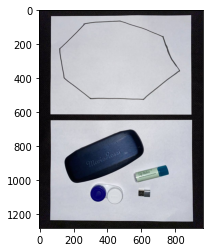

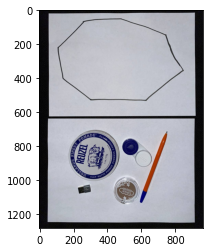

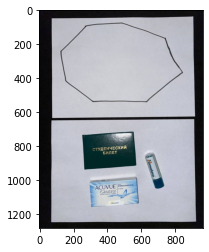

In [106]:
for i in range(1,4):
    img = _read_image("intelligent_placer_lib/inputImages/%i.jpeg" % i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

Найдем контуры листов, многоугольника и предметов

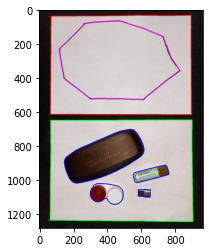

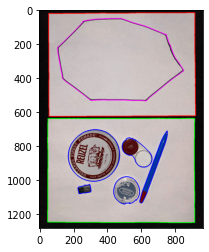

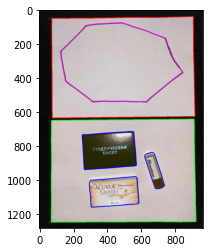

In [112]:
for i in range(1,4):
    img = _read_image("intelligent_placer_lib/inputImages/%i.jpeg" % i)
    contours = Contours.find_contours(img)
    draw_contours(contours, img)
    plt.imshow(img)
    plt.show()

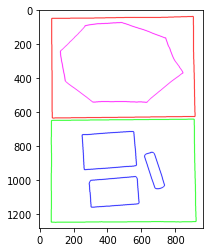

In [130]:
mask_image = imgs * 0 + 255
draw_contours(contours, mask_image)
plt.imshow(mask_image)